Made by:
*   19CS10039: Kaushal Banthia
*   19CS10073: Rajat Bachhawat

## Training the Decision Tree

### Import libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [13, 7]
import math

In [15]:
def accuracy_score(y_true, y_pred):
  y_true = list(y_true)
  y_pred = list(y_pred)
  if len(y_true) != len(y_pred):
    return "Size of lists containing actual and predicted values is not the same"
  accuracy = 0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
      accuracy += 1
  accuracy /= len(y_true)
  return accuracy

### Read the Data

In [16]:
data = pd.read_csv('Indian Liver Patient Dataset (ILPD).csv')
# Dropping any rows with even one null value
data.dropna(how = 'any', inplace = True)

### Analysing the Data

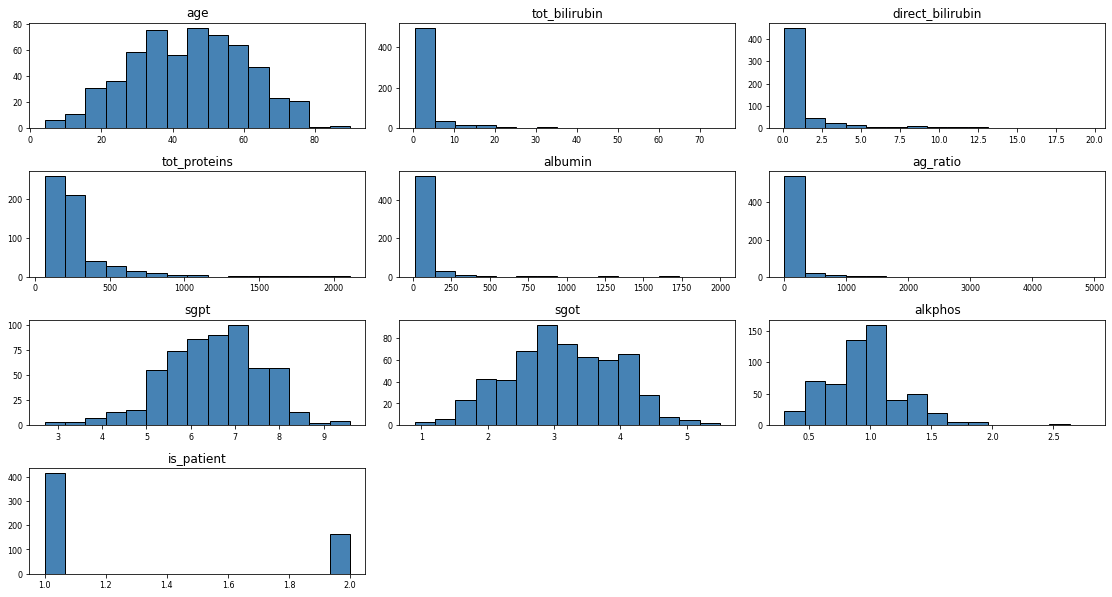

In [10]:
data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

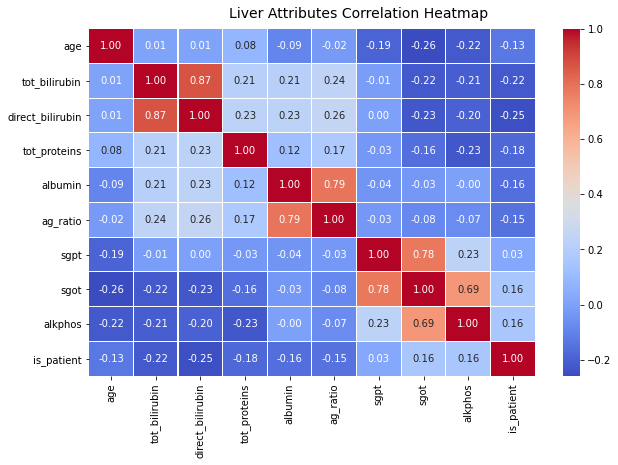

In [17]:
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Liver Attributes Correlation Heatmap', fontsize=14)

In [18]:
pp = sns.pairplot(data[data.columns], hue='is_patient', size=1.8, aspect=1.8, 
                  palette={1: "#FF9999", 2: "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Liver Attributes Pairwise Plots', fontsize=14)

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


In [ ]:
alette={1: "#FF9999", 2: "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Liver Attributes Pairwise Plots', fontsize=14)

In [ ]:
dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Liver Attributes Pairwise Plots', fontsize=14)

### Impurity Measure Calculation Functions

In [ ]:
def findEntropy(data):
  '''
  Calculate the entropy for the data in the current node
  '''
  totalCount = len(data)
  labels = data['is_patient'].unique()
  labelCounts = data['is_patient'].value_counts()
  
  entropy = 0
  for label in labels:
    if labelCounts[label] > 0:
      entropy -= (labelCounts[label]/totalCount)*math.log2(labelCounts[label]/totalCount)
  return entropy

In [ ]:
def findGini(data):
  '''
  Calculate the gini impurity for the data in the current node
  '''
  totalCount = len(data)
  labels = data['is_patient'].unique()
  labelCounts = data['is_patient'].value_counts()

  gini = 1
  for label in labels:
      probOfLabel = labelCounts[label]/totalCount
      gini -= probOfLabel ** 2
  return gini

In [ ]:
def findGain(currentImpurity, left, right, impurityMeasure):
  '''
  Calculate the information gain / gini gain given current node's impurity
  and the data at the two child nodes
  '''
  p = len(left) / (len(left) + len(right))
  return currentImpurity - (p * impurityMeasure(left) + (1 - p) * impurityMeasure(right))

### Data Splitting Functions

In [ ]:
def split(data, attribute, value):
  '''
  Split the examples in the current node based on the passed attribute-value pair
  If the values are continuous, classify >=value as TRUE else FALSE
  Else, classify ==value as TRUE else FALSE
  '''
  trueData = []
  falseData = []
  for idx, example in data.iterrows():
    if isinstance(value, (int, float)):
      if example[attribute] >= value:
        trueData.append(example)
      else:
        falseData.append(example)
    else:
      if example[attribute] == value:
        trueData.append(example)
      else:
        falseData.append(example)
  trueData = pd.DataFrame(trueData);
  falseData = pd.DataFrame(falseData);
  return trueData, falseData


In [ ]:
def findBestSplit(data, attributes, impurityFunction):
  '''
  Find the best splitting of the passed examples by checking for all attributes
  '''
  maxGain = 0
  bestAttribute = None
  bestValue = None
  currentImpurity = impurityFunction(data)

  for attribute in attributes:
    dataSorted = data.copy()
    dataSorted.sort_values(by = attribute, inplace = True)
    dataSorted.drop_duplicates(subset = [attribute], inplace = True)
    
    # print('Splitting Attribute: {}'.format(attribute))

    if attribute == 'gender':
      trueData, falseData = split(data, attribute, 'Male')
      
      if trueData.empty or falseData.empty:
        continue;
      
      gain = findGain(currentImpurity, trueData, falseData, impurityFunction)

      # print('-- Splitting Value, Gain: {}, {}'.format('Male', gain))

      if gain > maxGain:
        maxGain = gain
        bestAttribute, bestValue = attribute, 'Male'

    else:
      prevValue = 0
      prevLabel = 0
      i = 0
      for idx, example in dataSorted.iterrows():
        value = example[attribute]
        label = example['is_patient']

        if i > 0 and example['is_patient'] != prevLabel:
          meanValue = (value + prevValue)/2
          trueData, falseData = split(data, attribute, meanValue)

          if trueData.empty or falseData.empty:
            prevValue = value
            continue;
          
          gain = findGain(currentImpurity, trueData, falseData, impurityFunction)
          
          # print('-- Splitting Value, Gain: {}, {}'.format(meanValue, gain))
          
          if gain > maxGain:
            maxGain = gain
            bestAttribute, bestValue = attribute, value
        
        prevValue = value
        prevLabel = label
        i += 1
  return maxGain, bestAttribute, bestValue

### Node Class

In [ ]:
class Node:
  '''
  Decision Tree Node. Contains information about the attribute-value pair
  that it uses for splitting, right child and left child, the gain, the 
  vote value, the count of the labels and whether the node is a leaf node or not.
  '''
  def __init__(self, nodeID, gain, labelCounts, vote, isLeaf, splittingAttr, splittingVal, right, left):
    self.splittingAttr = splittingAttr
    self.splittingVal = splittingVal
    self.right = right
    self.left = left
    self.nodeID = nodeID
    self.gain = gain
    self.vote = vote
    self.labelCounts = labelCounts
    self.isLeaf = isLeaf

### Decision Tree Class

In [ ]:
class DecisionTree:
  def __init__(self, trainingData, maxDepth, impurityMeasure):
    self.trainingData = trainingData
    self.attributesLeft = list(trainingData.keys()[0:-1])
    self.maxDepth = maxDepth
    self.impurityMeasure = impurityMeasure
    self.depth = 0
    self.noOfNodes = 0
    self.decrementInAccuracy = 0 # Used for pruning
    self.root = self.buildTree(trainingData, 0)
  
  def buildTree(self, data, currDepth):
    '''
    Build the decision tree recursively given the training examples
    '''
    nodeID = self.noOfNodes
    self.noOfNodes += 1
    self.depth = max(self.depth, currDepth)
    # print('Current Depth = {}'.format(currDepth))
    gain, attribute, value = findBestSplit(data, self.attributesLeft, self.impurityMeasure)
    
    if attribute is not None:
      self.attributesLeft.remove(attribute)

    attributesCopy = self.attributesLeft.copy()
    
    labelCounts = data['is_patient'].value_counts()
    vote = data['is_patient'].value_counts().idxmax()
    
    if gain == 0 or currDepth == self.maxDepth: # Leaf
      return Node(nodeID, gain, labelCounts, vote, True, attribute, value, None, None)

    trueData, falseData = split(data, attribute, value)

    left = self.buildTree(falseData, currDepth + 1)

    self.attributesLeft = attributesCopy

    right = self.buildTree(trueData, currDepth + 1)

    return Node(nodeID, gain, labelCounts, vote, False, attribute, value, right, left)

  def classify(self, example, maxDepth_test):
    '''
    Given an example, this function classifies it and gives the output
    '''
    currNode = self.root
    currDepth = 0
    while not (currNode.isLeaf or currDepth == maxDepth_test):
      attribute = currNode.splittingAttr
      value = currNode.splittingVal
      if attribute == 'gender':
        if example[attribute] == value:
          currNode = currNode.right
        else:
          currNode = currNode.left
      else:
        if example[attribute] >= value:
          currNode = currNode.right
        else:
          currNode = currNode.left
      currDepth += 1
    return currNode.vote

  def predict(self, data, maxDepth_test = None):
    '''
    Returns the list of predictions made by the Decision Tree on the input Dataset
    '''
    if maxDepth_test is None:
      maxDepth_test = self.maxDepth

    totalCount = len(data)
    predictions = []
    for idx, example in data.iterrows():
      predicted = self.classify(example, maxDepth_test)
      predictions.append(predicted)
    return predictions
  
  def prune(self, valid):
    actual = valid['is_patient']
    bestAchieved = False

    while not bestAchieved:
      '''
      Prunes the tree according to the best candidate Node (Which causes the 
      highest increase in the accuracy). Makes use of the BFS traversal, 
      to go through the entire tree
      '''
      accuracyBeforePrune = accuracy_score(actual, self.predict(valid))
      bestAccuracy = 0
      bestPruneCandidate = None

      # BFS on the decision tree
      q = [self.root]  # queue for BFS
      while len(q) > 0:
        currNode = q.pop(0)
        if not currNode.isLeaf:
          currNode.isLeaf = True
          accuracyAfterPrune = accuracy_score(actual, self.predict(valid))
          if accuracyAfterPrune > accuracyBeforePrune - 0.0125:
            if accuracyAfterPrune > bestAccuracy:
              bestAccuracy = accuracyAfterPrune
              bestPruneCandidate = currNode
          currNode.isLeaf = False
          q.append(currNode.left)
          q.append(currNode.right)
      
      if bestPruneCandidate is None or self.decrementInAccuracy > 1:
        bestAchieved = True
      
      else:
        print('Pruned Node {}'.format(bestPruneCandidate.nodeID))
        bestPruneCandidate.isLeaf = True
        bestPruneCandidate.left = None
        bestPruneCandidate.right = None
        
        accuracyAfterPrune = accuracy_score(actual, self.predict(valid))
        if accuracyAfterPrune < accuracyBeforePrune:
            self.decrementInAccuracy += 1

## Testing the Decision Tree

### Choose Impurity Measure



In [ ]:
'''
findGini    : Make Gini the impurity measure to be used
findEntropy : Make Entropy the impurity measure to be used
'''
impurityFunction = findGini

### Q2: Accuracy over random 80/20 splits

In [ ]:
maxAccuracy = 0
avgAccuracy = 0
train_best, valid_best, test_best = None, None, None
i = 1
for seed in range(1,101,10):
  train, test = train_test_split(data, test_size = 0.2, random_state = seed, shuffle = True)
  train, valid = train_test_split(train, test_size = 0.2, random_state = seed, shuffle = True)

  dTree = DecisionTree(train, 1000, impurityFunction)
  predictions = dTree.predict(test, 1000)
  actual = test['is_patient']
  accuracy = accuracy_score(actual, predictions)

  print('Tree {} Accuracy = {} % Depth = {} No. Of Nodes = {}'.format(i, accuracy * 100, dTree.depth, dTree.noOfNodes))
  
  if accuracy > maxAccuracy:
    maxAccuracy = accuracy
    train_best, valid_best, test_best = train, valid, test
  
  avgAccuracy += accuracy
  i += 1
avgAccuracy /= 10

print('Average Accuracy over 10 random 80/20 splits = {} %'.format(avgAccuracy * 100))
print('Best Accuracy over 10 random 80/20 splits = {} %'.format(maxAccuracy * 100))

Tree 1 Accuracy = 58.620689655172406 % Depth = 10 No. Of Nodes = 119
Tree 2 Accuracy = 64.65517241379311 % Depth = 10 No. Of Nodes = 103
Tree 3 Accuracy = 69.82758620689656 % Depth = 10 No. Of Nodes = 87
Tree 4 Accuracy = 66.37931034482759 % Depth = 10 No. Of Nodes = 117
Tree 5 Accuracy = 66.37931034482759 % Depth = 10 No. Of Nodes = 123
Tree 6 Accuracy = 61.206896551724135 % Depth = 10 No. Of Nodes = 155
Tree 7 Accuracy = 65.51724137931035 % Depth = 10 No. Of Nodes = 113
Tree 8 Accuracy = 60.3448275862069 % Depth = 10 No. Of Nodes = 99
Tree 9 Accuracy = 67.24137931034483 % Depth = 10 No. Of Nodes = 89
Tree 10 Accuracy = 70.6896551724138 % Depth = 10 No. Of Nodes = 133
Average Accuracy over 10 random 80/20 splits = 65.08620689655172 %
Best Accuracy over 10 random 80/20 splits = 70.6896551724138 %


In [ ]:
# Decision Tree with Best Accuracy obtained in Q2
dTree1 = DecisionTree(train_best, 100, impurityFunction)

### Q3: a. Accuracy vs Depth of Tree

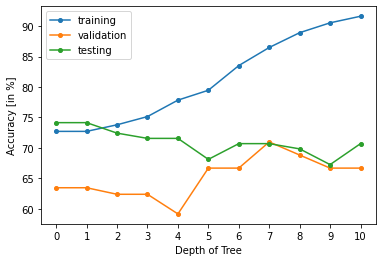

In [ ]:
actual_test = test_best['is_patient']
actual_valid = valid_best['is_patient']
actual_train = train_best['is_patient']

x = []
y_train = []
y_valid = []
y_test = []

for depth in range(0, dTree1.depth + 1):
  predictions_test = dTree1.predict(test_best, depth)
  predictions_valid = dTree1.predict(valid_best, depth)
  predictions_train = dTree1.predict(train_best, depth)
  
  x.append(depth)
  y_train.append(accuracy_score(actual_train, predictions_train) * 100)
  y_valid.append(accuracy_score(actual_valid, predictions_valid) * 100)
  y_test.append(accuracy_score(actual_test, predictions_test) * 100)

plt.plot(x, y_train, label = 'training', marker = 'o', markersize = 4)
plt.plot(x, y_valid, label = 'validation', marker = 'o', markersize = 4)
plt.plot(x, y_test, label = 'testing', marker = 'o', markersize = 4)
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy [in %]')
plt.xticks(np.arange(0, dTree1.depth + 1, step = 1))
plt.legend()

### Q3: b. Accuracy vs Number of Nodes in Tree

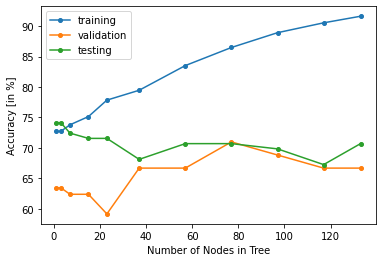

In [ ]:
actual_test = test_best['is_patient']
actual_valid = valid_best['is_patient']
actual_train = train_best['is_patient']

x = []
y_train = []
y_valid = []
y_test = []

for depth in range(0, dTree1.depth + 1):
  dTree = DecisionTree(train_best, depth, impurityFunction)
  predictions_test = dTree.predict(test_best, depth)
  predictions_valid = dTree.predict(valid_best, depth)
  predictions_train = dTree.predict(train_best, depth)
  
  x.append(dTree.noOfNodes)
  y_train.append(accuracy_score(actual_train, predictions_train) * 100)
  y_valid.append(accuracy_score(actual_valid, predictions_valid) * 100)
  y_test.append(accuracy_score(actual_test, predictions_test) * 100)

plt.plot(x, y_train, label = 'training', marker = 'o', markersize = 4)
plt.plot(x, y_valid, label = 'validation', marker = 'o', markersize = 4)
plt.plot(x, y_test, label = 'testing', marker = 'o', markersize = 4)
plt.xlabel('Number of Nodes in Tree')
plt.ylabel('Accuracy [in %]')
plt.legend()

### Q4: Post-pruning the Decision Tree

In [ ]:
# Accuracy Before Pruning
actual = test_best['is_patient']
predictions = dTree1.predict(test_best)
print('Accuracy before Pruning = {}%'.format(accuracy_score(actual, predictions) * 100))

# Accuracy After Pruning
dTree1.prune(valid_best)
predictions = dTree1.predict(test_best)
print('Accuracy after Pruning = {}%'.format(accuracy_score(actual, predictions) * 100))

Accuracy before Pruning = 70.6896551724138%
Pruned Node 85
Pruned Node 18
Pruned Node 65
Pruned Node 51
Pruned Node 126
Pruned Node 5
Pruned Node 119
Pruned Node 80
Accuracy after Pruning = 72.41379310344827%


In [ ]:
from sklearn.metrics import classification_report
print("Accuracy and other metrics after pruning")
print(classification_report(actual, predictions))

Accuracy and other metrics after pruning
              precision    recall  f1-score   support

           1       0.78      0.87      0.82        86
           2       0.45      0.30      0.36        30

    accuracy                           0.72       116
   macro avg       0.62      0.59      0.59       116
weighted avg       0.70      0.72      0.70       116



##### For Testing Purposes: (Not to be run when training and pruning the decision tree)

In [ ]:
def forcePrune(dTree, steps, valid):
  '''
  Forcibly prunes the maximum accuracy node for the number of steps specified.
  Prints a graph of accuracy vs number of nodes pruned
  '''
  actual_test = test_best['is_patient']
  actual_valid = valid_best['is_patient']
  actual_train = train_best['is_patient']

  x = []
  y_train = []
  y_valid = []
  y_test = []

  bestAchieved = False

  for i in range(0, steps):
    bestAccuracy = 0
    bestPruneCandidate = None

    # BFS on the decision tree
    q = [dTree.root]  # queue for BFS
    while len(q) > 0:
      currNode = q.pop(0)
      if not currNode.isLeaf:
        currNode.isLeaf = True
        accuracyAfterPrune = accuracy_score(actual_valid, dTree.predict(valid_best))
        if accuracyAfterPrune > bestAccuracy:
          bestAccuracy = accuracyAfterPrune
          bestPruneCandidate = currNode
        currNode.isLeaf = False
        q.append(currNode.left)
        q.append(currNode.right)
    
    if bestPruneCandidate is None:
      # If all nodes have been pruned and only a leaf remains
      break
    
    print('Pruned Node {}'.format(bestPruneCandidate.nodeID))
    bestPruneCandidate.isLeaf = True
    bestPruneCandidate.left = None
    bestPruneCandidate.right = None
    x.append(i+1)
    y_train.append(accuracy_score(actual_train, dTree.predict(train_best)) * 100)
    print(accuracy_score(actual_valid, dTree.predict(valid_best)) * 100)
    y_valid.append(accuracy_score(actual_valid, dTree.predict(valid_best)) * 100)
    y_test.append(accuracy_score(actual_test, dTree.predict(test_best)) * 100)

  plt.plot(x, y_train, label = 'training', marker = 'o', markersize = 4)
  plt.plot(x, y_valid, label = 'validation', marker = 'o', markersize = 4)
  plt.plot(x, y_test, label = 'testing', marker = 'o', markersize = 4)
  plt.xlabel('Number of Nodes Pruned')
  plt.ylabel('Accuracy [in %]')
  plt.xticks(np.arange(0, steps + 1, step = 1))
  plt.legend()

Pruned Node 85
68.81720430107528
Pruned Node 18
70.96774193548387
Pruned Node 65
72.04301075268818
Pruned Node 51
73.11827956989248
Pruned Node 126
73.11827956989248
Pruned Node 5
73.11827956989248
Pruned Node 119
73.11827956989248
Pruned Node 80
72.04301075268818
Pruned Node 4
69.89247311827957
Pruned Node 17
66.66666666666666
Pruned Node 0
63.44086021505376


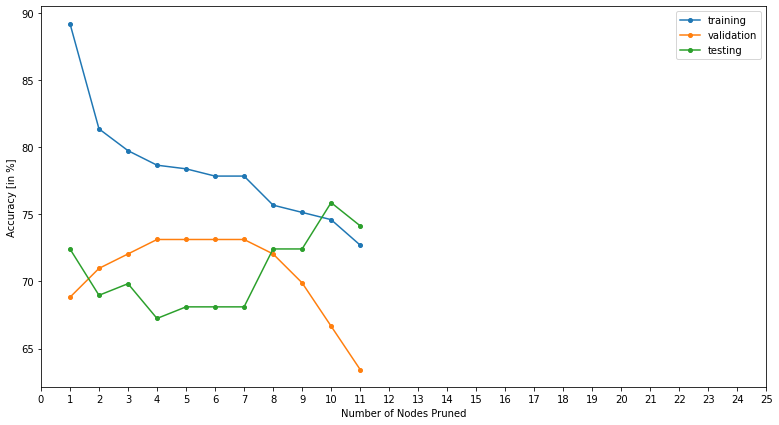

In [ ]:
forcePrune(dTree1, 25, valid_best)

### Q5: Printing the Pruned Decision Tree

In [ ]:
from graphviz import Digraph
import graphviz 
def nodeContent(node):
  '''
  Returns a formatted string which will be used 
  for printing the parameters inside the node when the graph 
  is created using graphviz
  Return
  '''
  label1 = 0
  label2 = 0
  if 1 in node.labelCounts.keys():
    label1 = node.labelCounts[1]
  if 2 in node.labelCounts.keys():
    label2 = node.labelCounts[2]
  
  if not node.isLeaf:
      return "Node ID = {}\nAttribute = {}\n[1, 2] = [{},{}]\nMajority Vote = {}".format(node.nodeID, node.splittingAttr, label1, label2, node.vote)
  
  return "Node ID = {}\n[1, 2] = [{},{}]\nMajority Vote = {}".format(node.nodeID, label1, label2, node.vote)


def printDecisionTree(dTree):
  '''
  Prints the decision tree graph so created 
  and saves the output in the a pdf file
  '''

  # create a new Digraph
  f = Digraph('Decision Tree', filename='decision_tree.gv')
  f.attr(rankdir='UD', size='1000,800')

  # Shape of the nodes set to rectangle
  f.attr('node', shape ='rectangle')

  # BFS on the decision tree to print the tree
  q = [dTree.root]  # queue for BFS

  while len(q) > 0:
    currNode = q.pop(0)

    sign = ('<','>=')
    if currNode.splittingAttr == 'gender':
      sign = ('!=','==')

    if not currNode.isLeaf:
      f.edge(nodeContent(currNode), nodeContent(currNode.left), label = sign[0] + str(currNode.splittingVal))
      q.append(currNode.left)
      f.edge(nodeContent(currNode), nodeContent(currNode.right), label = sign[1] + str(currNode.splittingVal))
      q.append(currNode.right)
    else:
      f.node(nodeContent(currNode))
          
  f.render('decision_tree.gv', view = True)

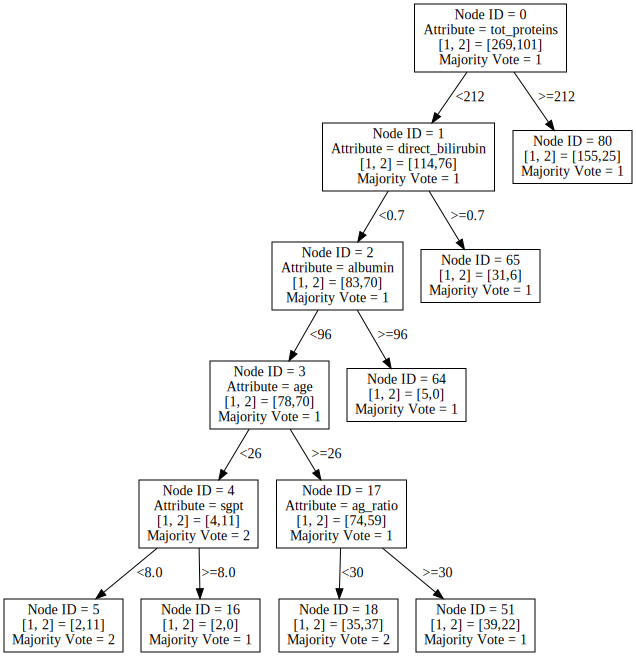

In [ ]:
printDecisionTree(dTree1)
with open("decision_tree.gv") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

##Repeating the entire process with the impurity measure now being entropy

In [ ]:
'''
findGini    : Make Gini the impurity measure to be used
findEntropy : Make Entropy the impurity measure to be used
'''
impurityFunction = findEntropy

### Q2: Accuracy over random 80/20 splits

In [ ]:
maxAccuracy = 0
avgAccuracy = 0
train_best, valid_best, test_best = None, None, None
i = 1
for seed in range(1,101,10):
  train, test = train_test_split(data, test_size = 0.2, random_state = seed, shuffle = True)
  train, valid = train_test_split(train, test_size = 0.2, random_state = seed, shuffle = True)

  dTree = DecisionTree(train, 1000, impurityFunction)
  predictions = dTree.predict(test, 1000)
  actual = test['is_patient']
  accuracy = accuracy_score(actual, predictions)

  print('Tree {} Accuracy = {} % Depth = {} No. Of Nodes = {}'.format(i, accuracy * 100, dTree.depth, dTree.noOfNodes))
  
  if accuracy > maxAccuracy:
    maxAccuracy = accuracy
    train_best, valid_best, test_best = train, valid, test
  
  avgAccuracy += accuracy
  i += 1
avgAccuracy /= 10

print('Average Accuracy over 10 random 80/20 splits = {} %'.format(avgAccuracy * 100))
print('Best Accuracy over 10 random 80/20 splits = {} %'.format(maxAccuracy * 100))

Tree 1 Accuracy = 58.620689655172406 % Depth = 10 No. Of Nodes = 107
Tree 2 Accuracy = 68.10344827586206 % Depth = 10 No. Of Nodes = 77
Tree 3 Accuracy = 68.10344827586206 % Depth = 10 No. Of Nodes = 75
Tree 4 Accuracy = 60.3448275862069 % Depth = 10 No. Of Nodes = 71
Tree 5 Accuracy = 69.82758620689656 % Depth = 10 No. Of Nodes = 83
Tree 6 Accuracy = 68.10344827586206 % Depth = 10 No. Of Nodes = 57
Tree 7 Accuracy = 63.793103448275865 % Depth = 10 No. Of Nodes = 61
Tree 8 Accuracy = 64.65517241379311 % Depth = 10 No. Of Nodes = 57
Tree 9 Accuracy = 68.96551724137932 % Depth = 10 No. Of Nodes = 87
Tree 10 Accuracy = 70.6896551724138 % Depth = 10 No. Of Nodes = 83
Average Accuracy over 10 random 80/20 splits = 66.12068965517241 %
Best Accuracy over 10 random 80/20 splits = 70.6896551724138 %


In [ ]:
# Decision Tree with Best Accuracy obtained in Q2
dTree1 = DecisionTree(train_best, 100, impurityFunction)

### Q3: a. Accuracy vs Depth of Tree

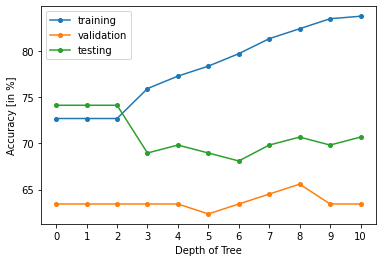

In [ ]:
actual_test = test_best['is_patient']
actual_valid = valid_best['is_patient']
actual_train = train_best['is_patient']

x = []
y_train = []
y_valid = []
y_test = []

for depth in range(0, dTree1.depth + 1):
  predictions_test = dTree1.predict(test_best, depth)
  predictions_valid = dTree1.predict(valid_best, depth)
  predictions_train = dTree1.predict(train_best, depth)
  
  x.append(depth)
  y_train.append(accuracy_score(actual_train, predictions_train) * 100)
  y_valid.append(accuracy_score(actual_valid, predictions_valid) * 100)
  y_test.append(accuracy_score(actual_test, predictions_test) * 100)

plt.plot(x, y_train, label = 'training', marker = 'o', markersize = 4)
plt.plot(x, y_valid, label = 'validation', marker = 'o', markersize = 4)
plt.plot(x, y_test, label = 'testing', marker = 'o', markersize = 4)
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy [in %]')
plt.xticks(np.arange(0, dTree1.depth + 1, step = 1))
plt.legend()

### Q3: b. Accuracy vs Number of Nodes in Tree

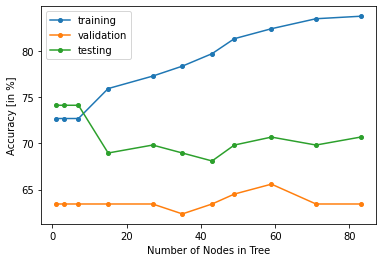

In [ ]:
actual_test = test_best['is_patient']
actual_valid = valid_best['is_patient']
actual_train = train_best['is_patient']

x = []
y_train = []
y_valid = []
y_test = []

for depth in range(0, dTree1.depth + 1):
  dTree = DecisionTree(train_best, depth, impurityFunction)
  predictions_test = dTree.predict(test_best, depth)
  predictions_valid = dTree.predict(valid_best, depth)
  predictions_train = dTree.predict(train_best, depth)
  
  x.append(dTree.noOfNodes)
  y_train.append(accuracy_score(actual_train, predictions_train) * 100)
  y_valid.append(accuracy_score(actual_valid, predictions_valid) * 100)
  y_test.append(accuracy_score(actual_test, predictions_test) * 100)

plt.plot(x, y_train, label = 'training', marker = 'o', markersize = 4)
plt.plot(x, y_valid, label = 'validation', marker = 'o', markersize = 4)
plt.plot(x, y_test, label = 'testing', marker = 'o', markersize = 4)
plt.xlabel('Number of Nodes in Tree')
plt.ylabel('Accuracy [in %]')
plt.legend()

### Q4: Post-pruning the Decision Tree

In [ ]:
# Accuracy Before Pruning
actual = test_best['is_patient']
predictions = dTree1.predict(test_best)
print('Accuracy before Pruning = {}%'.format(accuracy_score(actual, predictions) * 100))

# Accuracy After Pruning
dTree1.prune(valid_best)
predictions = dTree1.predict(test_best)
print('Accuracy after Pruning = {}%'.format(accuracy_score(actual, predictions) * 100))

Accuracy before Pruning = 70.6896551724138%
Pruned Node 72
Pruned Node 23
Pruned Node 54
Pruned Node 63
Pruned Node 3
Pruned Node 44
Pruned Node 49
Pruned Node 21
Pruned Node 20
Accuracy after Pruning = 72.41379310344827%


In [ ]:
from sklearn.metrics import classification_report
print("Accuracy and other metrics after pruning")
print(classification_report(actual, predictions))

Accuracy and other metrics after pruning
              precision    recall  f1-score   support

           1       0.75      0.95      0.84        86
           2       0.33      0.07      0.11        30

    accuracy                           0.72       116
   macro avg       0.54      0.51      0.47       116
weighted avg       0.64      0.72      0.65       116



##### For Testing Purposes: (Not to be run when training and pruning the decision tree)

Pruned Node 72
64.51612903225806
Pruned Node 23
65.59139784946237
Pruned Node 54
66.66666666666666
Pruned Node 63
66.66666666666666
Pruned Node 3
66.66666666666666
Pruned Node 44
66.66666666666666
Pruned Node 49
66.66666666666666
Pruned Node 21
65.59139784946237
Pruned Node 20
64.51612903225806
Pruned Node 0
63.44086021505376


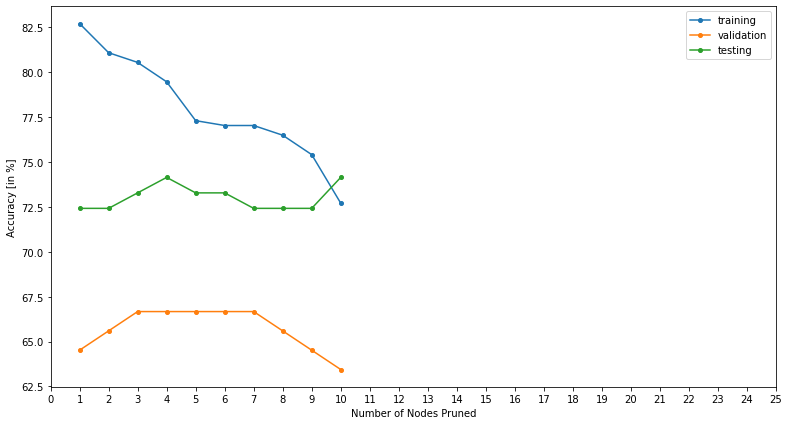

In [ ]:
forcePrune(dTree1, 25, valid_best)

### Q5: Printing the Pruned Decision Tree

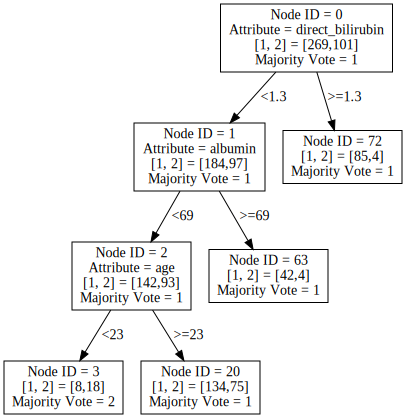

In [ ]:
printDecisionTree(dTree1)
with open("decision_tree.gv") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)